**HUMAN ACTIVITY RECOGNITION**






This project is about building a Human Activity recognition  system to be deployed in a web application.                                                For computing resources constraints, we used only 10 classes from [UCF-101](https://www.crcv.ucf.edu/data/UCF101.php).

Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import tensorflow as tf
import seaborn as sns
import os
import warnings
warnings.filterwarnings(action="ignore")
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from utility import utility
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm


2023-12-29 10:45:15.863095: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 10:45:16.129940: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-29 10:45:16.131449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 10:45:16.998279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
BASE_PATH = 'dataset/' #the folder that already contains the videos of interest
N_CPU_CORES = os.cpu_count() -1 # the number of cpu to use for paralization 
TEST_SIZE_RATIO = 0.2
IMG_SIZE = 224 #frame size
BATCH_SIZE = 64
EPOCHS = 40
MAX_SEQ_LENGTH = 20 #max number of frame to collect per videos
NUM_FEATURES = 2048  #size of the feature embedding resulting from convolution




# **1. Overview of the data**

To accomplish this task, we developed a function that go through the folders, extracting various characteristics such as **frame count, frames per second (fps), and duration** for each video and return them as a Dataframe object.

In [3]:
#get an overview of the dataset
dataset = utility.reading_data(BASE_PATH)

In [4]:
dataset.head()

,Label,video_path,Frame_count,fps,Duration (s)
0,TrampolineJumping,dataset/TrampolineJumping/v_TrampolineJumping_...,201,29.97003,6.706700
1,TrampolineJumping,dataset/TrampolineJumping/v_TrampolineJumping_...,151,29.97003,5.038367
2,TrampolineJumping,dataset/TrampolineJumping/v_TrampolineJumping_...,151,29.97003,5.038367
3,TrampolineJumping,dataset/TrampolineJumping/v_TrampolineJumping_...,296,29.97003,9.876533
4,TrampolineJumping,dataset/TrampolineJumping/v_TrampolineJumping_...,187,29.97003,6.239567


In [5]:
number_classes = len(dataset["Label"].unique())
number_classes

10

Are we dealing with an imbalanced dataset ?

In [6]:
print("Percentage of video per classes")
dataset.groupby("Label").count()["video_path"] / dataset.shape[0]

Percentage of video per classes


Label
ApplyEyeMakeup       0.112142
BabyCrawling         0.102088
Biking               0.103635
Billiards            0.116009
BrushingTeeth        0.101315
PizzaTossing         0.087394
PushUps              0.078886
Swing                0.101315
TrampolineJumping    0.092034
Typing               0.105182
Name: video_path, dtype: float64

No,our dataset is pretty much balanced

# **2.Preparing the data**

## 2.1 Utility functions

To achieve that, we will define some utility functions that will make our job easier.

## 2.2 Feature extraction using a pre-trained CNN





In [7]:
with ThreadPoolExecutor(max_workers=N_CPU_CORES) as executor:
  #load the videos in parallel on mutiple threads
  frames = tqdm(executor.map(utility.load_video,dataset['video_path']),desc="extracting frames from videos")
  #save the frames as dataframe
  videos_frames = np.array(list(frames))
   


extracting frames from videos: 37it [00:00, 170.86it/s]

extracting frames from videos: 1293it [00:05, 227.56it/s]


In [8]:
#apply the feature extractor on each frames previously
feature_extractor = utility.build_feature_extractor(IMG_SIZE) #create feature extractor object
with ThreadPoolExecutor(max_workers=N_CPU_CORES) as executor:
  #run the feature extraction in parallel 
  videos_frames_features = executor.map(feature_extractor.predict,videos_frames)
  videos_frames_features = np.array(list(videos_frames_features))


1/1 [==============================] - 4s 4s/step


In [9]:
print(f"The dataset we have has the following shape: {videos_frames_features.shape}")

The dataset we have has the following shape: (1293, 20, 2048)


## 2.3 Encode labels using labelencoder
Replace activity labels (Pushups, ApplyEyeMakeup,...etc) by integers.

In [10]:
label_processor = tf.keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(dataset["Label"]))
print(label_processor.get_vocabulary())

labels = dataset["Label"].values
labels = label_processor(labels[..., None]).numpy()

['ApplyEyeMakeup', 'BabyCrawling', 'Biking', 'Billiards', 'BrushingTeeth', 'PizzaTossing', 'PushUps', 'Swing', 'TrampolineJumping', 'Typing']


## 2.4 Divide the data into train and test

In [11]:
#define all the variables to be used
N = dataset.shape[0]
N_CLASSES = np.unique(dataset["Label"])
X_train, X_test, y_train, y_test = train_test_split(
    videos_frames_features,labels,
    test_size=TEST_SIZE_RATIO,random_state=N)

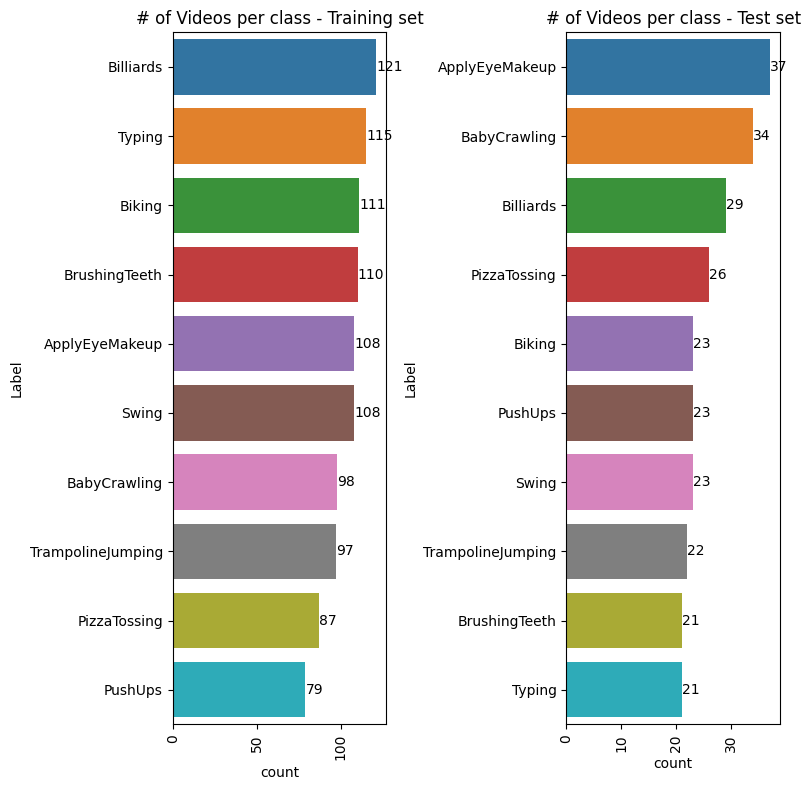

In [12]:
plt.figure(figsize=(8,8))

dataset_train,dataset_test = train_test_split(dataset,test_size=TEST_SIZE_RATIO,random_state=N)
#first subplot
plt.subplot(121)
plt.title("# of Videos per class - Training set")
ax1 = sns.countplot(data=dataset_train,y='Label',palette="tab10",
                    order=dataset_train['Label'].value_counts(ascending=False).index);
plt.xticks(rotation=90)

#second subplot
plt.subplot(122)
plt.title("# of Videos per class - Test set")
ax2 = sns.countplot(data=dataset_test,y='Label',palette="tab10",
                    order=dataset_test['Label'].value_counts(ascending=False).index)
plt.xticks(rotation=90)
plt.tight_layout()
for i,j in zip(ax1.containers,ax2.containers):
    ax1.bar_label(i)
    ax2.bar_label(j)


# **3.Training sequence models**

## 3.1 GRU

In [13]:
gru_model = utility.get_sequence_model("GRU",label_processor,MAX_SEQ_LENGTH,NUM_FEATURES)
print(gru_model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 2048)]        0         
                                                                 
 gru (GRU)                   (None, 20, 16)            99168     
                                                                 
 gru_1 (GRU)                 (None, 8)                 624       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 99954 (390.45 KB)
Trainable params: 99954 (390.

In [14]:
t1 = time.time()
_, gru_model = utility.run_experiment("GRU",label_processor,X_train,y_train,X_test,y_test)
gru_t2 = time.time() - t1
print(f"Training took {gru_t2} s")

Epoch 1/40
23/23 [==============================] - 14s 108ms/step - loss: 2.1420 - accuracy: 0.2102 - val_loss: 2.0547 - val_accuracy: 0.2508
Epoch 2/40
23/23 [==============================] - 0s 18ms/step - loss: 2.0308 - accuracy: 0.2573 - val_loss: 1.8922 - val_accuracy: 0.3408
Epoch 3/40
23/23 [==============================] - 0s 18ms/step - loss: 1.9026 - accuracy: 0.3278 - val_loss: 1.7853 - val_accuracy: 0.4534
Epoch 4/40
23/23 [==============================] - 0s 16ms/step - loss: 1.7899 - accuracy: 0.3762 - val_loss: 1.6592 - val_accuracy: 0.4984
Epoch 5/40
23/23 [==============================] - 0s 16ms/step - loss: 1.6822 - accuracy: 0.4716 - val_loss: 1.5180 - val_accuracy: 0.6785
Epoch 6/40
23/23 [==============================] - 0s 16ms/step - loss: 1.5546 - accuracy: 0.5297 - val_loss: 1.3889 - val_accuracy: 0.7299
Epoch 7/40
23/23 [==============================] - 0s 16ms/step - loss: 1.4423 - accuracy: 0.5809 - val_loss: 1.2912 - val_accuracy: 0.7524
Epoch 8/40


**Prediction**

In [15]:
y_pred = gru_model.predict(X_test)
print(classification_report(y_test,np.argmax(y_pred,axis=1)))

9/9 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.94      0.94      0.94        34
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        29
           4       0.95      1.00      0.98        21
           5       0.93      0.96      0.94        26
           6       1.00      0.83      0.90        23
           7       1.00      1.00      1.00        23
           8       1.00      1.00      1.00        22
           9       0.91      1.00      0.95        21

    accuracy                           0.97       259
   macro avg       0.97      0.97      0.97       259
weighted avg       0.97      0.97      0.97       259



<Axes: >

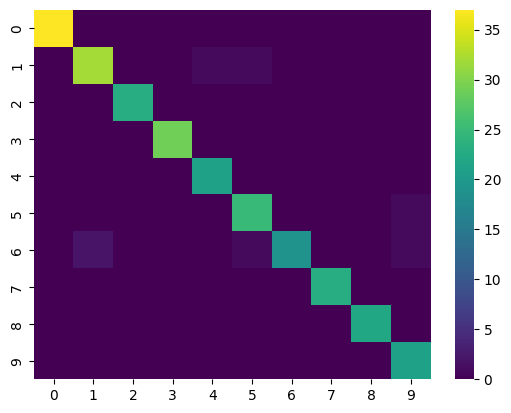

In [16]:
#confusion matrix
sns.heatmap(confusion_matrix(y_test,np.argmax(y_pred,axis=1)),cmap="viridis")

## 3.2 LSTM  

In [17]:
lstm_model = utility.get_sequence_model("LSTM",label_processor,MAX_SEQ_LENGTH,NUM_FEATURES)
print(lstm_model.summary())


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20, 2048)]        0         
                                                                 
 lstm (LSTM)                 (None, 20, 16)            132160    
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 10)                90        
                                                                 
Total params: 133122 (520.01 KB)
Trainable params: 133122 (

In [18]:
t1 = time.time()
_, lstm_model = utility.run_experiment("LSTM",label_processor,X_train,y_train,X_test,y_test)
lstm_t2 = time.time() - t1
print(f"Training of LSTM took {lstm_t2}")

Epoch 1/40
23/23 [==============================] - 3s 43ms/step - loss: 2.1753 - accuracy: 0.1936 - val_loss: 2.0809 - val_accuracy: 0.2476
Epoch 2/40
23/23 [==============================] - 0s 16ms/step - loss: 2.0389 - accuracy: 0.2462 - val_loss: 1.9418 - val_accuracy: 0.3698
Epoch 3/40
23/23 [==============================] - 0s 16ms/step - loss: 1.9034 - accuracy: 0.3292 - val_loss: 1.8216 - val_accuracy: 0.5016
Epoch 4/40
23/23 [==============================] - 0s 16ms/step - loss: 1.7854 - accuracy: 0.3831 - val_loss: 1.7012 - val_accuracy: 0.6013
Epoch 5/40
23/23 [==============================] - 0s 16ms/step - loss: 1.7081 - accuracy: 0.4163 - val_loss: 1.5868 - val_accuracy: 0.6013
Epoch 6/40
23/23 [==============================] - 0s 16ms/step - loss: 1.6316 - accuracy: 0.4398 - val_loss: 1.5738 - val_accuracy: 0.5370
Epoch 7/40
23/23 [==============================] - 0s 16ms/step - loss: 1.5805 - accuracy: 0.4578 - val_loss: 1.5566 - val_accuracy: 0.5209
Epoch 8/40
23

In [19]:
y_pred_lstm = lstm_model.predict(X_test)
print(classification_report(y_test,np.argmax(y_pred_lstm,axis=1)))

9/9 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        37
           1       0.63      0.76      0.69        34
           2       0.96      0.96      0.96        23
           3       1.00      1.00      1.00        29
           4       0.83      0.95      0.89        21
           5       0.93      0.96      0.94        26
           6       0.76      0.83      0.79        23
           7       0.92      0.48      0.63        23
           8       0.91      0.95      0.93        22
           9       1.00      1.00      1.00        21

    accuracy                           0.88       259
   macro avg       0.89      0.88      0.88       259
weighted avg       0.89      0.88      0.87       259



<Axes: >

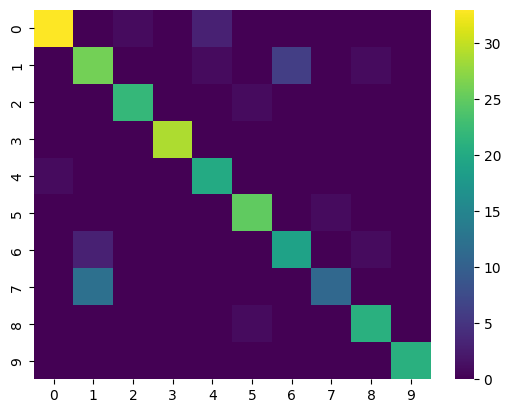

In [20]:
#confusion matrix
sns.heatmap(confusion_matrix(y_test,np.argmax(y_pred_lstm,axis=1)),cmap="viridis")

## 3.3 BI-LSTM

In [21]:
bilstm_model = utility.get_sequence_model("BILSTM",label_processor,MAX_SEQ_LENGTH,NUM_FEATURES)
print(bilstm_model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 20, 2048)]        0         
                                                                 
 bidirectional (Bidirection  (None, 20, 32)            264320    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 16)                2624      
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                                 
 dense_9 (Dense)             (None, 10)                90  

In [22]:
t1 = time.time()
_, bilstm_model = utility.run_experiment("BILSTM",label_processor,X_train,y_train,X_test,y_test)
blstm_t2 = time.time() - t1
print(f'Training of BILSTM took : {blstm_t2} s')

Epoch 1/40
23/23 [==============================] - 6s 69ms/step - loss: 2.1263 - accuracy: 0.1660 - val_loss: 1.8674 - val_accuracy: 0.3601
Epoch 2/40
23/23 [==============================] - 1s 24ms/step - loss: 1.8527 - accuracy: 0.3402 - val_loss: 1.6858 - val_accuracy: 0.5145
Epoch 3/40
23/23 [==============================] - 1s 25ms/step - loss: 1.6826 - accuracy: 0.4149 - val_loss: 1.4759 - val_accuracy: 0.6174
Epoch 4/40
23/23 [==============================] - 1s 25ms/step - loss: 1.4833 - accuracy: 0.5380 - val_loss: 1.3034 - val_accuracy: 0.7621
Epoch 5/40
23/23 [==============================] - 1s 24ms/step - loss: 1.3442 - accuracy: 0.6044 - val_loss: 1.2152 - val_accuracy: 0.7685
Epoch 6/40
23/23 [==============================] - 1s 24ms/step - loss: 1.2589 - accuracy: 0.6196 - val_loss: 1.1009 - val_accuracy: 0.7331
Epoch 7/40
23/23 [==============================] - 1s 26ms/step - loss: 1.2446 - accuracy: 0.6376 - val_loss: 1.0176 - val_accuracy: 0.7717
Epoch 8/40
23

In [23]:
y_pred_bilstm = bilstm_model.predict(X_test)
print(classification_report(y_test,np.argmax(y_pred_bilstm,axis=1)))

9/9 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        37
           1       0.97      0.88      0.92        34
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        29
           4       0.95      0.90      0.93        21
           5       1.00      0.92      0.96        26
           6       0.85      0.96      0.90        23
           7       1.00      1.00      1.00        23
           8       0.92      1.00      0.96        22
           9       1.00      1.00      1.00        21

    accuracy                           0.97       259
   macro avg       0.97      0.97      0.97       259
weighted avg       0.97      0.97      0.97       259



<Axes: >

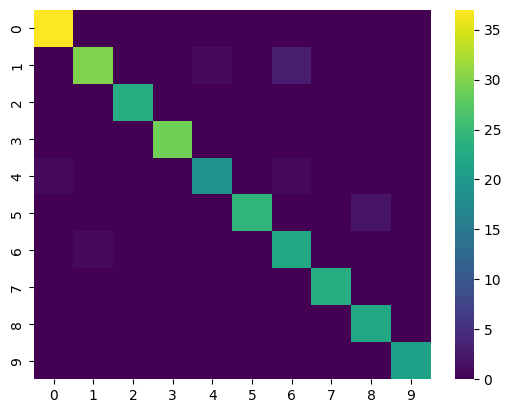

In [24]:
sns.heatmap(confusion_matrix(y_test,np.argmax(y_pred_bilstm,axis=1)),cmap="viridis")

# **4.Results**


**Testing the model using a random video downloaded from internet**

The test video downloaded from the internet shows a man doing pushups


In [25]:
test_online_video_path = "test/PushUp.mp4"

In [26]:
frames = utility.load_video(test_online_video_path)
class_vocab = label_processor.get_vocabulary()
frame_features = feature_extractor.predict(frames).reshape(1,20,2048)
probabilities = gru_model.predict(frame_features)[0]
max_label = class_vocab[np.argsort(probabilities)[-1]]
for i in np.argsort(probabilities)[::-1]:
    print(f"{class_vocab[i]}: {probabilities[i] * 100:5.2f}%")

1/1 [==============================] - 0s 16ms/step
PushUps: 89.14%
ApplyEyeMakeup:  4.78%
PizzaTossing:  2.42%
Typing:  2.28%
BrushingTeeth:  1.23%
Billiards:  0.10%
BabyCrawling:  0.02%
Biking:  0.02%
TrampolineJumping:  0.01%
Swing:  0.00%


**Comment:**

From the training and testing accuracy results of our trained models (LSTM, GRU, and BILSTM), it's clear they excel in classifying human activities. Assessing the confusion matrices for each model, we notice values being 0 almost everywhere around the diagonal, showcasing remarkable performance. Yet, considering the training duration, BILSTM takes nearly double the time of LSTM and GRU models. Consequently, we'll opt for **LSTM** as our deployment model for production.

In [27]:
#save the model to be deployed in production

In [28]:
lstm_model.save("models/final_model.h5")